In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

In [38]:
df = pd.read_csv('../flight_data.csv')
df = df[['DEPARTING_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND', 'DEP_DEL15']]
df = df.dropna()
df = df[(df['PRCP'] > 0) | (df['SNOW'] > 0) | (df['SNWD'] > 0)]

# Exploratory Data Analysis

In [39]:
# Summary statistics
print(df.describe())

               PRCP          SNOW          SNWD          TMAX          AWND  \
count  2.040284e+06  2.040284e+06  2.040284e+06  2.040284e+06  2.040284e+06   
mean   3.298348e-01  1.004809e-01  2.910892e-01  6.603272e+01  9.220871e+00   
std    5.477771e-01  5.592078e-01  1.275971e+00  1.940030e+01  3.750086e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+01  0.000000e+00   
25%    3.000000e-02  0.000000e+00  0.000000e+00  5.200000e+01  6.490000e+00   
50%    1.300000e-01  0.000000e+00  0.000000e+00  6.800000e+01  8.720000e+00   
75%    4.100000e-01  0.000000e+00  0.000000e+00  8.200000e+01  1.141000e+01   
max    1.163000e+01  1.720000e+01  2.520000e+01  1.140000e+02  3.378000e+01   

          DEP_DEL15  
count  2.040284e+06  
mean   2.407037e-01  
std    4.275109e-01  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00  


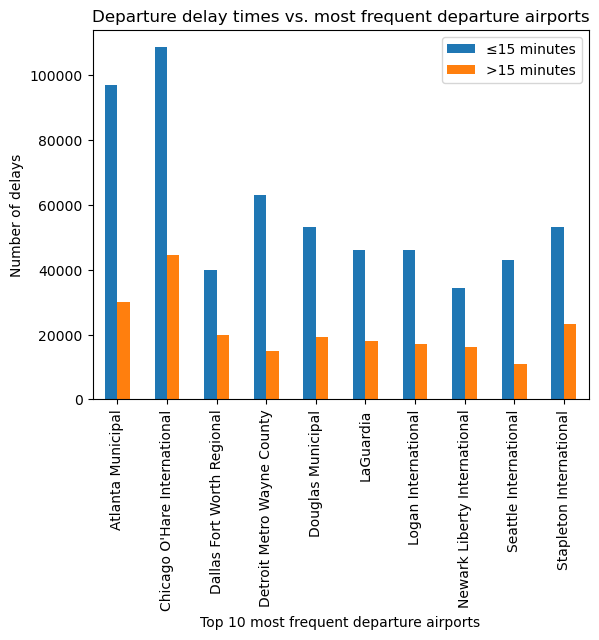

In [40]:
# Top 10 airports
top_airports = df['DEPARTING_AIRPORT'].value_counts().index[:10]
df_filtered = df[df['DEPARTING_AIRPORT'].isin(top_airports)]

# Bar chart
grouped = df_filtered.groupby(['DEPARTING_AIRPORT', 'DEP_DEL15']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=False)
plt.title('Departure delay times vs. most frequent departure airports')
plt.xlabel('Top 10 most frequent departure airports')
plt.ylabel('Number of delays')
plt.legend(['≤15 minutes', '>15 minutes']) 
plt.show()

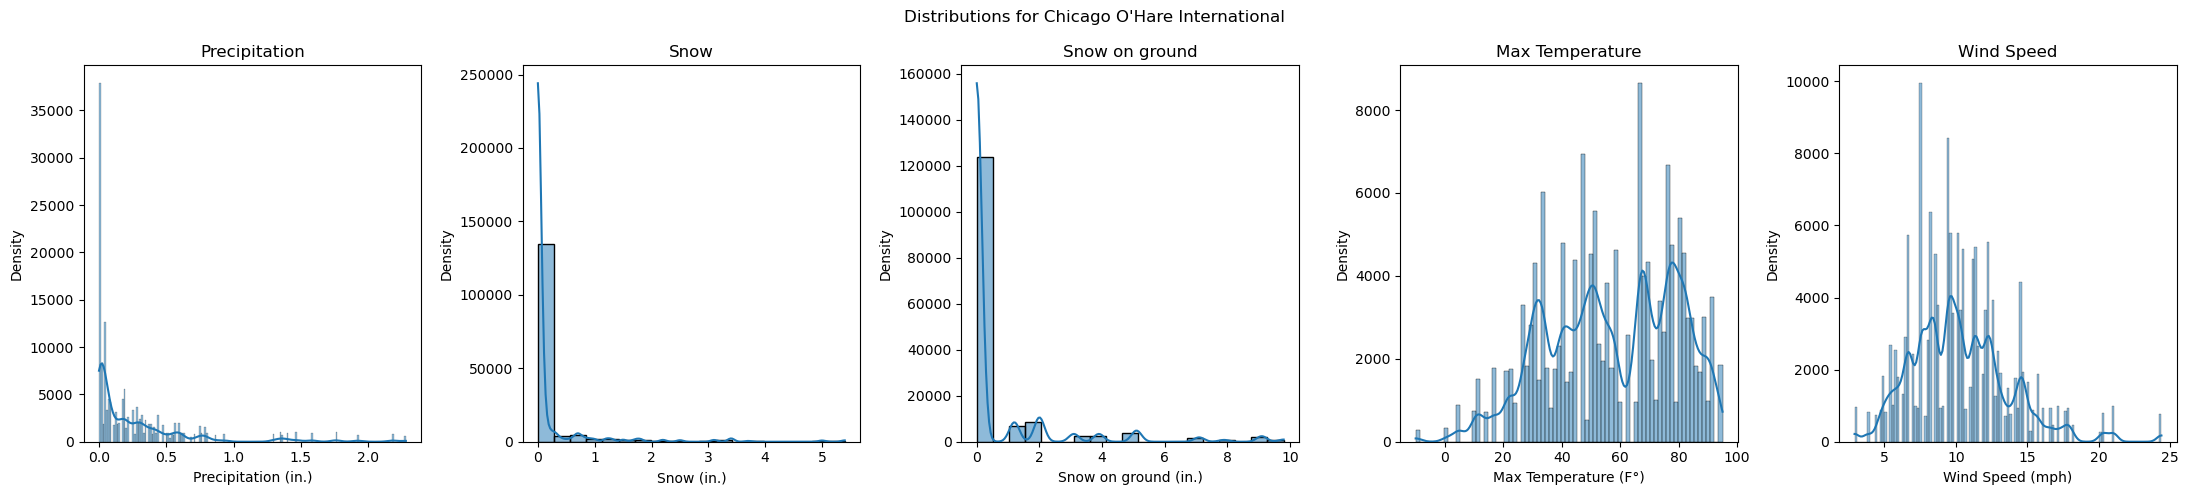

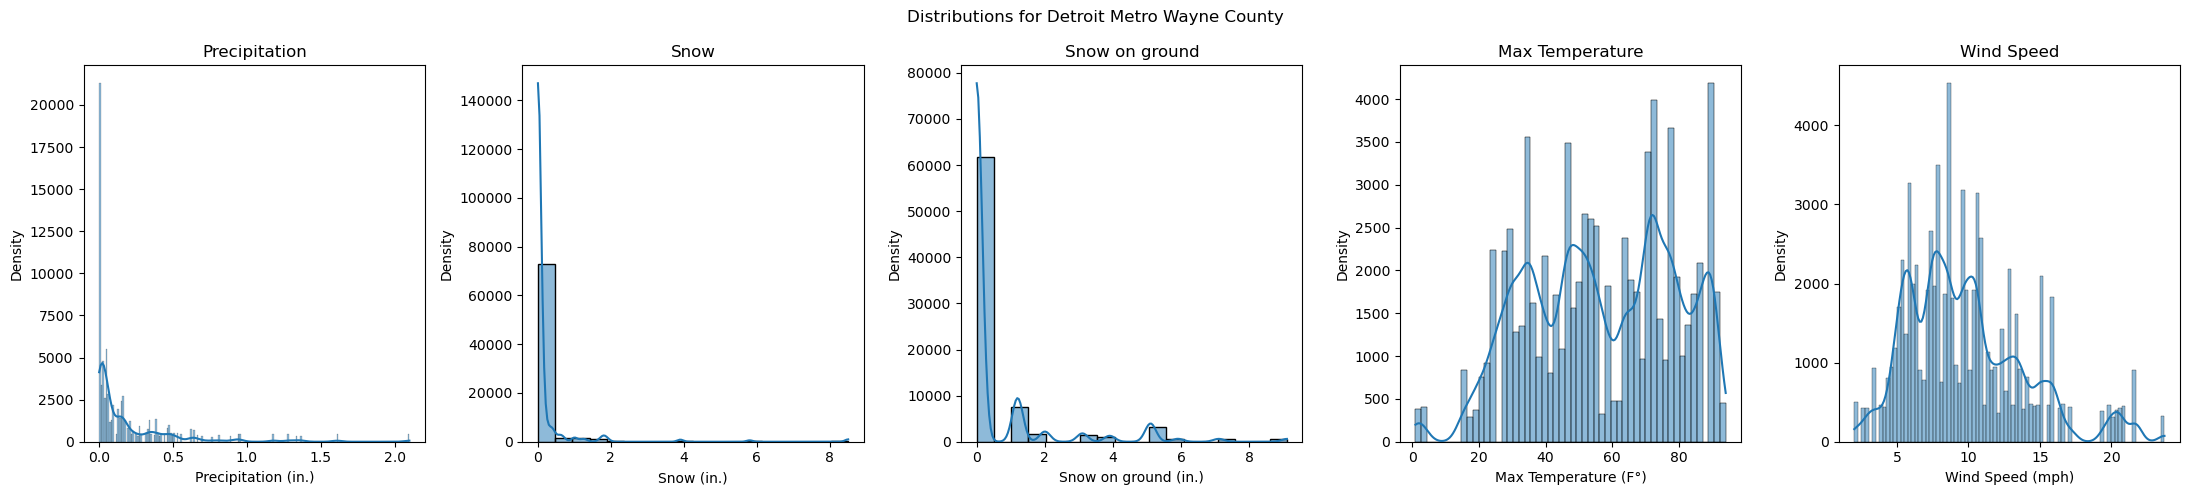

In [41]:
top_airports = ['Chicago O\'Hare International', 'Detroit Metro Wayne County']
df_filtered = df[df['DEPARTING_AIRPORT'].isin(top_airports)]

# Distributions
variables = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']
titles = ['Precipitation', 'Snow', 'Snow on ground', 'Max Temperature', 'Wind Speed']
x_labels = ['Precipitation (in.)', 'Snow (in.)', 'Snow on ground (in.)', 'Max Temperature (F°)', 'Wind Speed (mph)']
for airport in top_airports:
    fig, axs = plt.subplots(1, len(variables), figsize=(22, 5))
    fig.suptitle(f'Distributions for {airport}')
    for i, var in enumerate(variables):
        sns.histplot(df_filtered[df_filtered['DEPARTING_AIRPORT'] == airport][var], kde=True, ax=axs[i])
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(x_labels[i])
        axs[i].set_ylabel('Density')
    plt.tight_layout()
    plt.show()

## Normalize Features

In [42]:
scaler = StandardScaler()
df[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']] = scaler.fit_transform(
    df[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']])

## Dimensionality Reduction

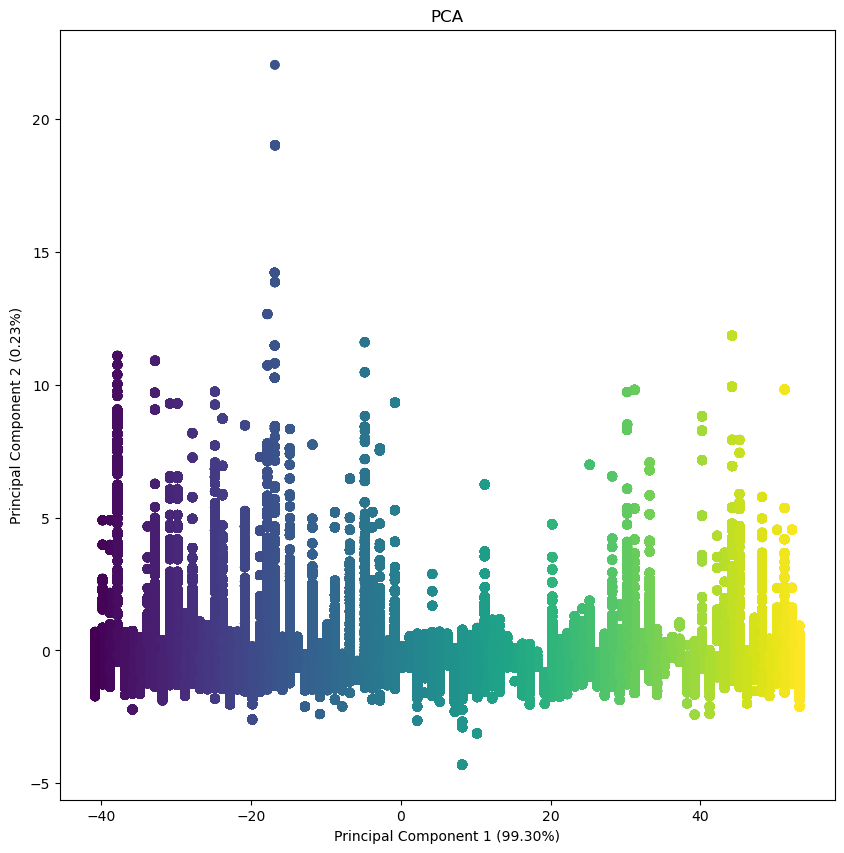

In [43]:
# Encode 'DEPARTING_AIRPORT' feature
temp = df
le = LabelEncoder()
temp['DEPARTING_AIRPORT'] = le.fit_transform(temp['DEPARTING_AIRPORT'])

# Dimensionality reduction with PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(temp)

# % of variance explained by each component
explained_variance = pca.explained_variance_ratio_

# Plot
fig, axs = plt.subplots(1, figsize=(10, 10))
axs.scatter(pca_results[:, 0], pca_results[:, 1],
            c=temp['DEPARTING_AIRPORT'])
axs.set_title('PCA')
axs.set_xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}%)')
axs.set_ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}%)')
plt.show()

# Modeling

## Train Test Split

In [44]:
X = df.drop('DEP_DEL15', axis=1)
y = df['DEP_DEL15']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

Accuracy: 0.7587935018882166
Precision: 0.46697300402067776
Sensitivity: 0.9970039968232035
Specificity: 0.008269674807498652


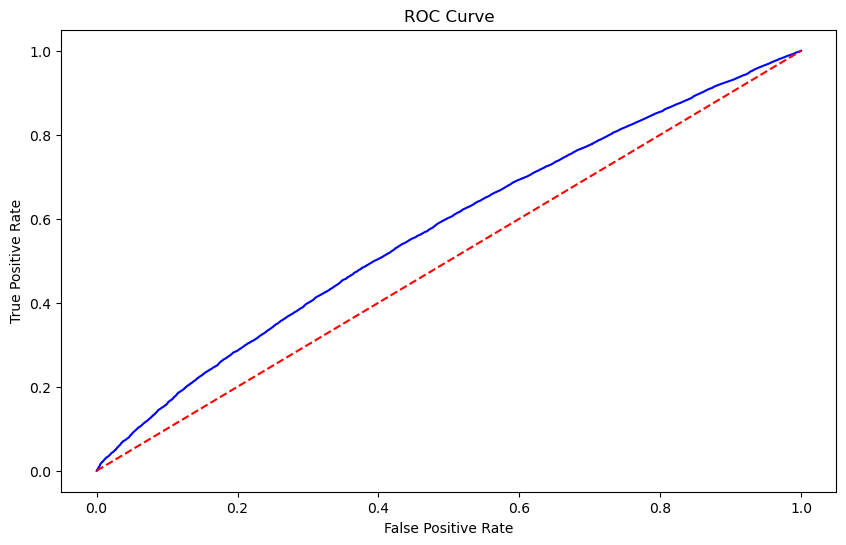

AUC: 0.5719638935640518


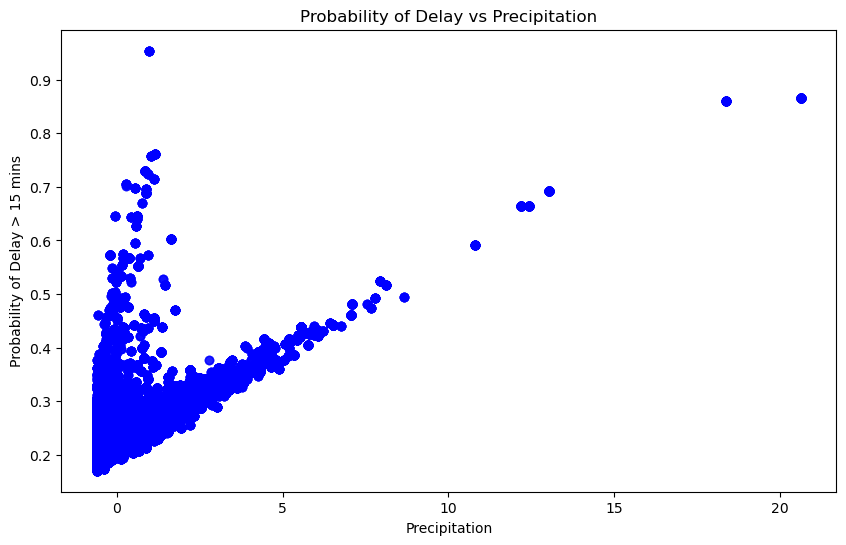

In [45]:
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate sensitivity (recall) and specificity
cm = confusion_matrix(y_test, y_pred)
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# ROC curve and AUC
probabilities = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

auc = roc_auc_score(y_test, probabilities)
print("AUC:", auc)


probabilities = log_reg.predict_proba(X_test)[:, 1]
plt.figure(figsize=(10, 6))
plt.scatter(X_test['PRCP'], probabilities, color='blue',
            alpha=0.5)  # Assuming PRCP is the first feature
plt.xlabel('Precipitation')
plt.ylabel('Probability of Delay > 15 mins')
plt.title('Probability of Delay vs Precipitation')
plt.show()

## Diagnostics

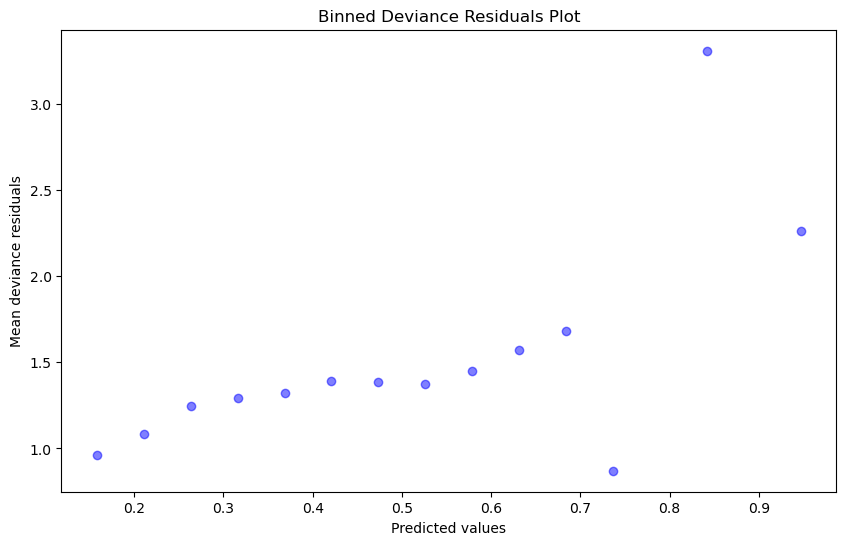

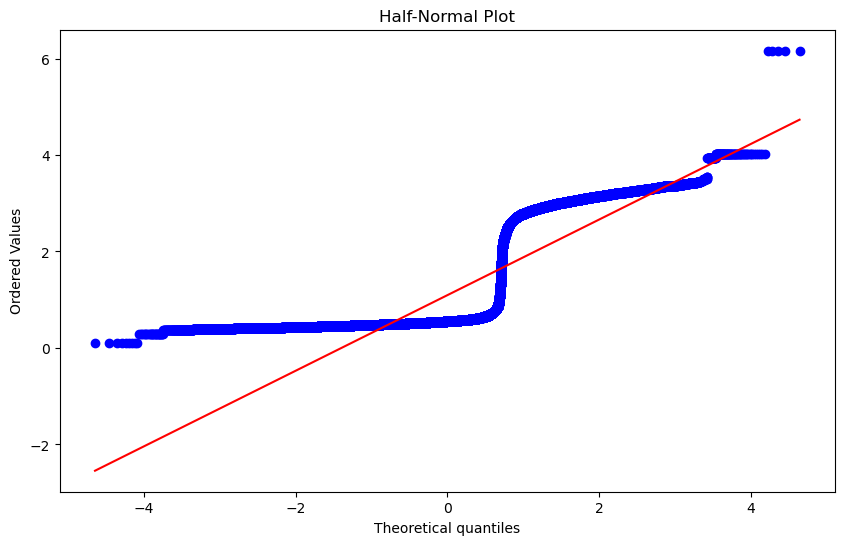

In [47]:
# Calculate deviance residuals
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
dev_resid = -2 * (y_test * np.log(y_pred_prob) +
                  (1 - y_test) * np.log(1 - y_pred_prob))

# Binned Deviance Residuals Plot
bins = np.linspace(0, 1, 20)
which_bin = np.digitize(y_pred_prob, bins=bins)
bin_means = [dev_resid[which_bin == i].mean() for i in range(1, len(bins))]
plt.figure(figsize=(10, 6))
plt.scatter(bins[:-1], bin_means, color='blue', alpha=0.5)
plt.xlabel('Predicted values')
plt.ylabel('Mean deviance residuals')
plt.title('Binned Deviance Residuals Plot')
plt.show()

# Half-Normal Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
res = stats.probplot(dev_resid, dist=stats.norm, plot=ax)
ax.set_title('Half-Normal Plot')
plt.show()